In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import warnings
warnings.simplefilter('ignore')
from prophet import Prophet

In [129]:
#read the data
df = pd.read_csv("DailyDataFinal.csv", parse_dates=['date'], delimiter=',')

In [130]:
#check the dtypes
print(df.dtypes)

campaign name                           object
date                            datetime64[ns]
clicks                                   int64
impressions                              int64
cost_micros                              int64
bidding_strategy_type                   object
conversions                            float64
cost_per_conversion                    float64
Click-through rate (CTR)               float64
average cost per click (CPC)           float64
cost-per-acquisition (CPA)             float64
Cost                                   float64
conversion_per_euro                    float64
budget                                   int64
isholiday                                int64
dtype: object


In [131]:
df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')

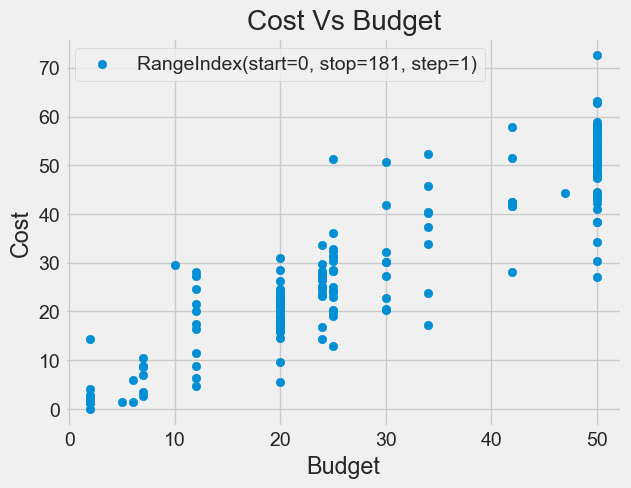

In [132]:
plt.scatter(df['budget'],df['Cost'],label=df.index)
# for i, name in enumerate(df.index):
#     plt.annotate(name, (df.budget[i], df.Cost[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize plot (add labels, title, etc.)
plt.xlabel('Budget')
plt.ylabel('Cost')
plt.title('Cost Vs Budget')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
df.head(3)

,campaign name,date,clicks,impressions,cost_micros,bidding_strategy_type,conversions,cost_per_conversion,Click-through rate (CTR),average cost per click (CPC),cost-per-acquisition (CPA),Cost,conversion_per_euro,budget,isholiday
0,SHOPTIMISED PMax-46 - all products-M,2023-11-28,0,33,0,MAXIMIZE_CONVERSION_VALUE,0.0,NaN,0.000000,0.000000,0.000000,0.00,0.000000,2,0
1,SHOPTIMISED PMax-46 - all products-M,2023-11-29,11,1139,4060000,MAXIMIZE_CONVERSION_VALUE,1.0,4060000.0,0.965759,0.369091,4.060000,4.06,0.246305,2,0
2,SHOPTIMISED PMax-46 - all products-M,2023-11-30,7,655,1430000,MAXIMIZE_CONVERSION_VALUE,0.0,NaN,1.068702,0.204286,4.085714,1.43,0.000000,5,0


In [134]:
df.drop(['campaign name','clicks','impressions','cost_micros','bidding_strategy_type','cost_per_conversion','Click-through rate (CTR)','average cost per click (CPC)','cost-per-acquisition (CPA)','conversion_per_euro','Cost'],axis=1, inplace=True)

In [135]:
df.head(5)

,date,conversions,budget,isholiday
0,2023-11-28,0.000000,2,0
1,2023-11-29,1.000000,2,0
2,2023-11-30,0.000000,5,0
3,2023-12-01,0.000000,7,0
4,2023-12-02,3.332276,7,0


In [136]:
df.date.dt.year

0      2023
1      2023
2      2023
3      2023
4      2023
       ... 
176    2024
177    2024
178    2024
179    2024
180    2024
Name: date, Length: 181, dtype: int32

In [137]:
df['year']=df.date.dt.year
df['month']=df.date.dt.month
df['day']=df.date.dt.day
df['week']=df.date.dt.dayofweek

In [138]:
df

,date,conversions,budget,isholiday,year,month,day,week
0,2023-11-28,0.000000,2,0,2023,11,28,1
1,2023-11-29,1.000000,2,0,2023,11,29,2
2,2023-11-30,0.000000,5,0,2023,11,30,3
3,2023-12-01,0.000000,7,0,2023,12,1,4
4,2023-12-02,3.332276,7,0,2023,12,2,5
...,...,...,...,...,...,...,...,...
176,2024-05-22,1.000000,20,0,2024,5,22,2
177,2024-05-23,2.000000,20,0,2024,5,23,3
178,2024-05-24,1.000000,20,0,2024,5,24,4
179,2024-05-25,0.998544,20,0,2024,5,25,5


In [139]:
def applyer(row):
    if row.dayofweek==5 or row.dayofweek==6:
        return 1
    else:
        return 0

In [140]:
df['isweekend']=df['date'].apply(applyer)
df

,date,conversions,budget,isholiday,year,month,day,week,isweekend
0,2023-11-28,0.000000,2,0,2023,11,28,1,0
1,2023-11-29,1.000000,2,0,2023,11,29,2,0
2,2023-11-30,0.000000,5,0,2023,11,30,3,0
3,2023-12-01,0.000000,7,0,2023,12,1,4,0
4,2023-12-02,3.332276,7,0,2023,12,2,5,1
...,...,...,...,...,...,...,...,...,...
176,2024-05-22,1.000000,20,0,2024,5,22,2,0
177,2024-05-23,2.000000,20,0,2024,5,23,3,0
178,2024-05-24,1.000000,20,0,2024,5,24,4,0
179,2024-05-25,0.998544,20,0,2024,5,25,5,1


## conversion

In [141]:
conv =df.rename(columns={'date': 'ds', 'conversions': 'y'})

In [142]:
#creating the train and validation set
train = conv[:int(0.8*(len(conv)))]
valid = conv[int(0.8*(len(conv))):]

In [143]:
train.dtypes

ds           datetime64[ns]
y                   float64
budget                int64
isholiday             int64
year                  int32
month                 int32
day                   int32
week                  int32
isweekend             int64
dtype: object

In [144]:
train.head(5)

,ds,y,budget,isholiday,year,month,day,week,isweekend
0,2023-11-28,0.000000,2,0,2023,11,28,1,0
1,2023-11-29,1.000000,2,0,2023,11,29,2,0
2,2023-11-30,0.000000,5,0,2023,11,30,3,0
3,2023-12-01,0.000000,7,0,2023,12,1,4,0
4,2023-12-02,3.332276,7,0,2023,12,2,5,1


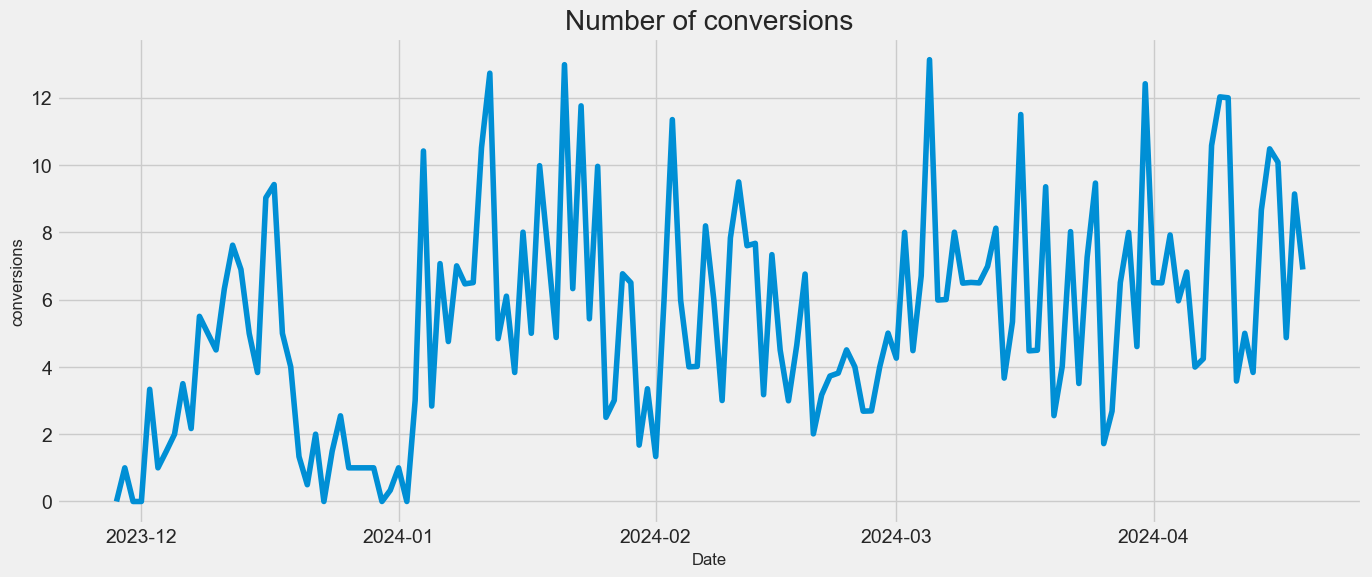

In [145]:
plt.figure(figsize = (15, 6))
plt.plot(train['ds'], train['y'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('conversions', {'fontsize': 12})
plt.title('Number of conversions')
plt.show()

In [146]:
#fit the model
model = Prophet()
model.add_regressor('budget')
model.add_regressor('isholiday')
model.add_regressor('year')
model.add_regressor('month')
model.add_regressor('day')
model.add_regressor('week')
model.add_regressor('isweekend')
model.fit(train)

12:18:33 - cmdstanpy - INFO - Chain [1] start processing
12:18:33 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
valid_predict=model.predict(valid.drop('y',axis=1))

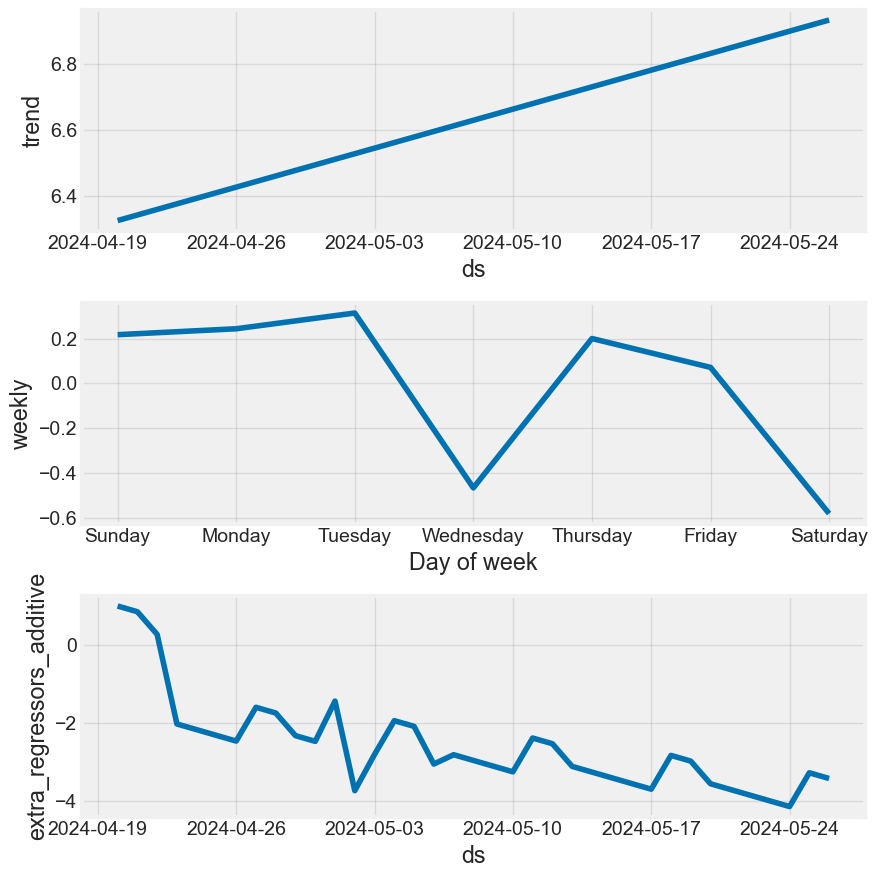

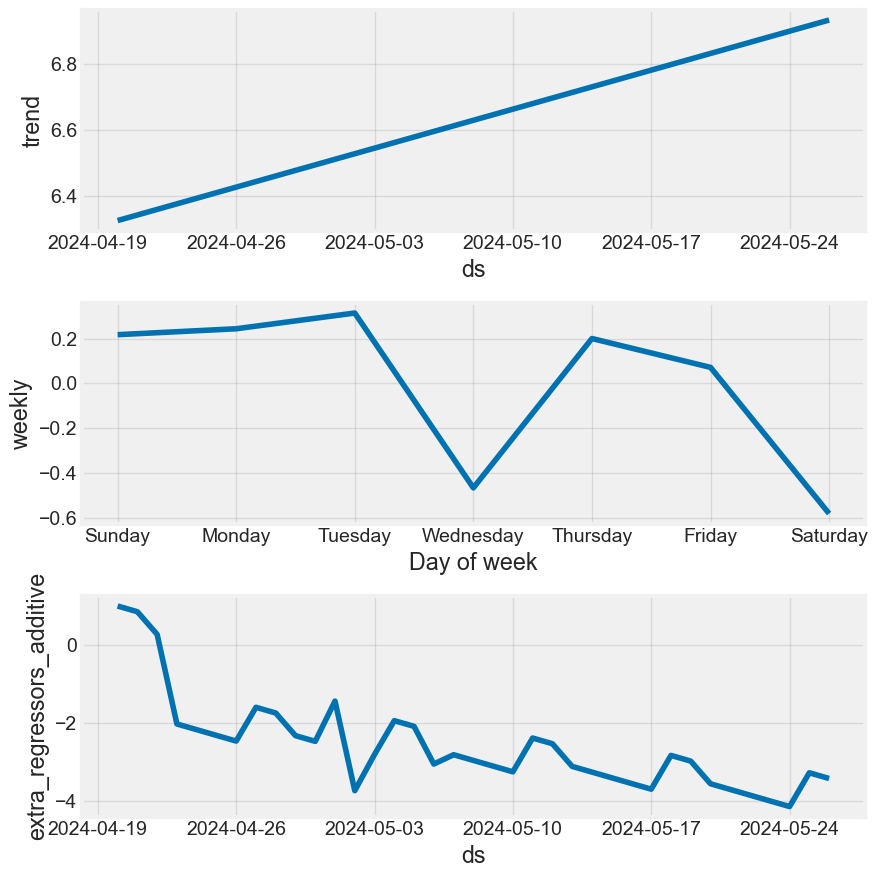

In [148]:
model.plot_components(valid_predict)

In [149]:
predicted=pd.DataFrame()
predicted['date']=valid_predict.ds
predicted['conversions']=valid_predict.yhat
predicted['budget']=valid_predict.budget
predicted['isholiday']=valid_predict.isholiday
predicted['year']=valid_predict.year
predicted['month']=valid_predict.month
predicted['day']=valid_predict.day
predicted['week']=valid_predict.week
predicted['isweekend']=valid_predict.isweekend

In [150]:
actual=pd.DataFrame()
actual['date']=valid.ds
actual['conversions']=valid.y
actual['budget']=valid.budget
actual['isholiday']=valid.isholiday
actual['year']=valid.year
actual['month']=valid.month
actual['day']=valid.day
actual['week']=valid.week
actual['isweekend']=valid.isweekend

In [151]:
actual.set_index(actual.date,inplace=True)
predicted.set_index(predicted.date,inplace=True)
actual

,date,conversions,budget,isholiday,year,month,day,week,isweekend
date,,,,,,,,,
2024-04-20,2024-04-20,6.016440,50,0,2024,4,20,5,1
2024-04-21,2024-04-21,5.166667,50,0,2024,4,21,6,1
2024-04-22,2024-04-22,4.321665,50,0,2024,4,22,0,0
2024-04-23,2024-04-23,6.358181,30,0,2024,4,23,1,0
2024-04-24,2024-04-24,4.527653,30,0,2024,4,24,2,0
2024-04-25,2024-04-25,5.234060,30,0,2024,4,25,3,0
2024-04-26,2024-04-26,9.095239,30,0,2024,4,26,4,0
2024-04-27,2024-04-27,10.127772,30,0,2024,4,27,5,1
2024-04-28,2024-04-28,4.161246,30,0,2024,4,28,6,1


In [152]:
predicted

,date,conversions,budget,isholiday,year,month,day,week,isweekend
date,,,,,,,,,
2024-04-20,2024-04-20,6.743082,1.908353,0.000000,-1.897353,0.441528,-0.300606,-0.166138,1.012279
2024-04-21,2024-04-21,7.412814,1.908353,0.000000,-1.897353,0.441528,-0.364263,-0.248634,1.012279
2024-04-22,2024-04-22,6.875099,1.908353,0.000000,-1.897353,0.441528,-0.427921,0.246342,0.000000
2024-04-23,2024-04-23,4.664112,-0.243588,0.000000,-1.897353,0.441528,-0.491579,0.163846,0.000000
2024-04-24,2024-04-24,3.753800,-0.243588,0.000000,-1.897353,0.441528,-0.555236,0.081350,0.000000
2024-04-25,2024-04-25,4.291542,-0.243588,0.000000,-1.897353,0.441528,-0.618894,-0.001146,0.000000
2024-04-26,2024-04-26,4.033291,-0.243588,0.000000,-1.897353,0.441528,-0.682552,-0.083642,0.000000
2024-04-27,2024-04-27,4.263274,-0.243588,0.000000,-1.897353,0.441528,-0.746209,-0.166138,1.012279
2024-04-28,2024-04-28,4.933006,-0.243588,0.000000,-1.897353,0.441528,-0.809867,-0.248634,1.012279


In [153]:
#Combine the actual result and predicted result side by side
result=pd.DataFrame()

result['Actual Conversions']=actual['conversions']
result['PredictedConversions']=predicted['conversions']

# result['Actual Cost']=actual['cost']
# result['Predicted Cost']=predicted['cost']

# result['Actual week']=actual['week']
# result['Predicted week']=predicted['week']


In [154]:
result.tail(30)

,Actual Conversions,PredictedConversions
date,,
2024-04-27,10.127772,4.263274
2024-04-28,4.161246,4.933006
2024-04-29,4.998920,4.395292
2024-04-30,4.000000,4.336245
2024-05-01,1.000000,4.604858
2024-05-02,3.002452,2.990659
2024-05-03,6.543285,3.808379
2024-05-04,1.250000,4.038362
2024-05-05,4.333333,4.708094


In [155]:
#check rmse
cols = train.columns
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('rmse value is : ', sqrt(mean_squared_error(result['PredictedConversions'], result['Actual Conversions'])))
print('mse value is : ', mean_squared_error(result['PredictedConversions'], result['Actual Conversions']))
print('mean absolute error is : ', mean_absolute_error(result['Actual Conversions'], result['PredictedConversions']))

rmse value is :  2.098121183884591
mse value is :  4.402112502265278
mean absolute error is :  1.6659724698651963


In [156]:
finalModel = Prophet()
finalModel.add_regressor('budget')
finalModel.add_regressor('isholiday')
finalModel.add_regressor('year')
finalModel.add_regressor('month')
finalModel.add_regressor('day')
finalModel.add_regressor('week')
finalModel.add_regressor('isweekend')
finalModel.fit(conv)

12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


In [157]:
future = finalModel.make_future_dataframe(periods=10)
future['budget']=20
future['isholiday']=0
future['year']=future.ds.dt.year
future['month']=future.ds.dt.month
future['day']=future.ds.dt.day
future['week']=future.ds.dt.dayofweek
future['isweekend']=future.ds.apply(applyer)
future.tail(15)

,ds,budget,isholiday,year,month,day,week,isweekend
176,2024-05-22,20,0,2024,5,22,2,0
177,2024-05-23,20,0,2024,5,23,3,0
178,2024-05-24,20,0,2024,5,24,4,0
179,2024-05-25,20,0,2024,5,25,5,1
180,2024-05-26,20,0,2024,5,26,6,1
181,2024-05-27,20,0,2024,5,27,0,0
182,2024-05-28,20,0,2024,5,28,1,0
183,2024-05-29,20,0,2024,5,29,2,0
184,2024-05-30,20,0,2024,5,30,3,0
185,2024-05-31,20,0,2024,5,31,4,0


In [158]:
finalPrediction=model.predict(future)

In [159]:
finalPrediction.tail(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,budget,...,weekly,weekly_lower,weekly_upper,year,year_lower,year_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
176,2024-05-22,6.864671,-0.542688,5.788965,6.864669,6.864672,-4.319383,-4.319383,-4.319383,-1.319558,...,-0.466623,-0.466623,-0.466623,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,2.545288
177,2024-05-23,6.881490,-0.207673,6.361012,6.881489,6.881492,-3.798461,-3.798461,-3.798461,-1.319558,...,0.200452,0.200452,0.200452,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,3.083030
178,2024-05-24,6.898310,-0.457837,6.213538,6.898308,6.898312,-4.073531,-4.073531,-4.073531,-1.319558,...,0.071536,0.071536,0.071536,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,2.824779
179,2024-05-25,6.915130,-0.155446,6.382746,6.915128,6.915131,-3.860367,-3.860367,-3.860367,-1.319558,...,-0.581426,-0.581426,-0.581426,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,3.054762
180,2024-05-26,6.931949,0.625321,6.658449,6.931947,6.931951,-3.207455,-3.207455,-3.207455,-1.319558,...,0.217640,0.217640,0.217640,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,3.724494
181,2024-05-27,6.948769,0.134709,6.705765,6.948767,6.948771,-3.761989,-3.761989,-3.761989,-1.319558,...,0.244067,0.244067,0.244067,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,3.186780
182,2024-05-28,6.965588,-0.025387,6.287338,6.965586,6.965590,-3.837855,-3.837855,-3.837855,-1.319558,...,0.314354,0.314354,0.314354,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,3.127733
183,2024-05-29,6.982408,-0.646048,5.659150,6.982406,6.982410,-4.764987,-4.764987,-4.764987,-1.319558,...,-0.466623,-0.466623,-0.466623,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,2.217421
184,2024-05-30,6.999227,-0.905946,5.901985,6.999225,6.999230,-4.244064,-4.244064,-4.244064,-1.319558,...,0.200452,0.200452,0.200452,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,2.755163
185,2024-05-31,7.016047,-0.770625,5.816758,7.016045,7.016049,-4.519135,-4.519135,-4.519135,-1.319558,...,0.071536,0.071536,0.071536,-1.897353,-1.897353,-1.897353,0.0,0.0,0.0,2.496912


In [160]:
finalResult=pd.DataFrame()
finalResult['Date']=finalPrediction['ds']
finalResult['Forecasted Conversion']=finalPrediction['yhat']
finalResult['Actual Conversion']=conv.y

In [161]:
finalResult.tail(15)

,Date,Forecasted Conversion,Actual Conversion
176,2024-05-22,2.545288,1.000000
177,2024-05-23,3.083030,2.000000
178,2024-05-24,2.824779,1.000000
179,2024-05-25,3.054762,0.998544
180,2024-05-26,3.724494,3.250000
181,2024-05-27,3.186780,NaN
182,2024-05-28,3.127733,NaN
183,2024-05-29,2.217421,NaN
184,2024-05-30,2.755163,NaN
185,2024-05-31,2.496912,NaN
